In [92]:
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x2088cf53670>)

In [93]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


The print command prints the total number of characters followed by the first 99 characters of this file for illustration purposes:

Our goal is to tokenize this 20,479-character short story into individual words and special characters that we can then turn into embeddings for LLM training.

In [94]:
import re
text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [95]:
result = re.split(r'([,.]|\s)', text) # splitting commas and punctuations
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [96]:
result = [item for item in result if item.strip()] # Remove whitespace due to redundancy
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


When developing a simple tokenizer, whether we should encode whitespaces as separate characters or just remove them depends on our application and its requirements. Removing whitespaces reduces the memory and computing requirements. However, keeping whitespaces can be useful if we train models that are sensitive to the exact structure of the text

In [97]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [98]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [99]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [100]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


"A dictionary named vocab is created where each unique word from a list, all_words, is given a unique number. Then, the code prints the first 51 word-number pairs from this dictionary."
Code below

In [101]:
"A dictionary named vocab is created where each unique word from a list, all_words, is given a unique number. Then, the code prints the first 51 word-number pairs from this dictionary."
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


This code creates a basic tokenizer tool.

The SimpleTokenizerV1 class is a tool that converts text to numbers and numbers back to text.

Encoding (encode): A method that takes text and converts it into a list of numbers.

Decoding (decode): A method that takes a list of numbers and converts it back into text.

In [102]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids]) 

        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [103]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," 
       Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


The preceding code prints the following token IDs:

In [104]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


Based on this output, we can see that the decode method successfully converted the token IDs back into the original text.

In [105]:
# text = "Hello, do you like tea?"
# print(tokenizer.encode(text)) # Gives an error 

The problem is that the word “Hello” was not used in the “The Verdict” short story. Hence, it is not contained in the vocabulary. This highlights the need to consider large and diverse training sets to extend the vocabulary when working on LLMs.

In [106]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}

print(len(vocab.items()))

1132


Based on the output of this print statement, the new vocabulary size is 1,132 (the previous vocabulary size was 1,130).

In [107]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


Gemini: 
he most notable change is the inclusion of a new line of code:
preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]

This line of code introduces a new feature that prevents the program from crashing when it encounters a word that isn't in its vocabulary. If a word is not found in the self.str_to_int dictionary, it is replaced with a special placeholder token, <|unk|>. This makes the tokenizer more robust, as it can now handle and encode any text, even if it contains words it has never seen before.
Code below

In [108]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        preprocessed = [item if item in self.str_to_int
                        else "<|unk|>" for item in preprocessed]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])

        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

Compared to the SimpleTokenizerV1 we implemented in listing 2.3, the new SimpleTokenizerV2 replaces unknown words with <|unk|> tokens.

In [109]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [110]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [111]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


Based on comparing this detokenized text with the original input text, we know that the training dataset, Edith Wharton’s short story “The Verdict,” does not contain the words “Hello” and “palace.”

The <|unk|> token stands for “unknown” and is used to represent any word that is not in the vocabulary built from the training data. When the tokenizer encounters a word it doesn’t know, it replaces it with <|unk|> so the model can still process the input without errors. This is important for handling new or rare words that the model hasn’t seen before.

In [112]:
!pip install tiktoken

In [113]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.11.0


In [114]:
#Once installed, we can instantiate the BPE tokenizer from tiktoken as follows:
tokenizer = tiktoken.get_encoding("gpt2")

In [115]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [116]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


In [117]:
text = (
    "Akwirw ier"
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[33901, 86, 343, 86, 220, 959]


In [118]:
strings = tokenizer.decode(integers)
print(strings)

Akwirw ier


Now we want to make a data-loader like in the image where we fetch input-target pairs with a sliding window approach: 
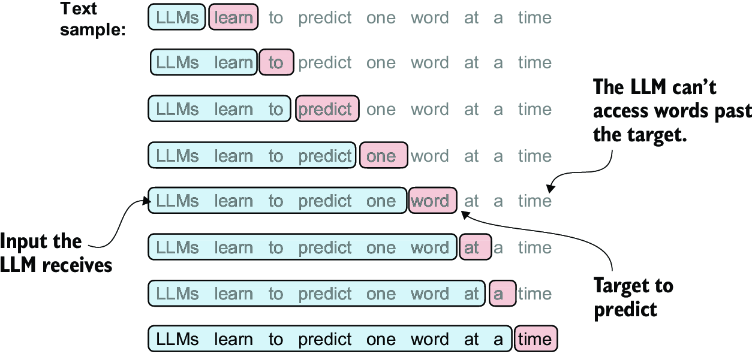

In [119]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


Next, we remove the first 50 tokens from the dataset for demonstration purposes, as it results in a slightly more interesting text passage in the next steps:

In [120]:
enc_sample = enc_text[50:]

One of the easiest and most intuitive ways to create the input–target pairs for the next-word prediction task is to create two variables, x and y, where x contains the input tokens and y contains the targets, which are the inputs shifted by 1:

In [121]:
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


By processing the inputs along with the targets, which are the inputs shifted by one position, we can create the next-word prediction tasks (see figure 2.12), as follows:

In [122]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [123]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


This code, written in Python, is used to prepare text data for a GPT (Generative Pre-trained Transformer) model. The `GPTDatasetV1` class is defined for this purpose. Text is processed and broken down into smaller, sequential chunks. These chunks are then converted into numerical tensors, with each chunk being separated into an input sequence and a corresponding target sequence. The target sequence is created by shifting the input sequence by one token, which is a common practice for training language models to predict the next word in a sequence. The `__len__` method allows for the determination of the total number of data samples, while the `__getitem__` method enables a specific data sample to be retrieved by its index.
CODE BELOW

In [124]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]



A PyTorch DataLoader for a GPT model is created by this function. It uses a GPT-2 tokenizer to process text, preparing it as a GPTDatasetV1 object. The DataLoader then efficiently handles the data in batches, with options for shuffling, dropping incomplete batches, and using multiple worker processes for faster loading. CODE BELOW

In [125]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [126]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

dataloader = create_dataloader_v1(
    raw_text, batch_size=2, max_length=8, stride=2, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[   40,   367,  2885,  1464,  1807,  3619,   402,   271],
        [ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138]]), tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899],
        [ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]])]


GEMINI: In the provided Python code, several parameters are used to configure the creation of a data loader for processing text. An explanation of these parameters is as follows:

* `raw_text`: This parameter holds the complete text that is to be processed. It is the full input data from which smaller text sequences will be extracted for training a model.
* `batch_size=2`: This determines the number of text sequences that are processed at one time. A batch size of 2 means that two input sequences and their corresponding target sequences will be processed together as a single batch.
* `max_length=8`: This parameter specifies the length of each individual text sequence. Each input sequence will be composed of eight tokens, and each target sequence will also have a length of eight tokens. This is the size of the "window" that moves over the text.
* `stride=2`: This parameter dictates how the input window moves across the text. A stride of 2 means that after the first sequence is extracted, the next sequence will begin two tokens after the start of the previous one. A smaller stride results in more overlapping between sequences, while a larger stride leads to less overlap.
* `shuffle=False`: This controls the order in which the data is presented. When `shuffle` is set to `False`, the data sequences are processed in their original, sequential order. If it were set to `True`, the order of the sequences would be randomized before being passed to the model.

The first_batch variable contains two tensors: the first tensor stores the input token IDs, and the second tensor stores the target token IDs. Since the max_length is set to 4, each of the two tensors contains four token IDs. Note that an input size of 4 is quite small and only chosen for simplicity. It is common to train LLMs with input sizes of at least 256.

GEMINI: 
The dataloader processes the raw text, which begins with "The verdict". The tokenizer converts this text into a sequence of tokens. The token IDs for "The verdict" are likely 40 (for "The") and 367 (for "verdict").

The first tensor, tensor([[ 40, 367, 2885, 1464]]), represents the input token IDs. The first input sequence is composed of the first four tokens from the text, which correspond to "The verdict" and two subsequent tokens.

The second tensor, tensor([[ 367, 2885, 1464, 1807]]), represents the target token IDs. In this type of language model training, the target sequence is shifted by one position relative to the input sequence. This means the model is trained to predict the next token in the sequence. For example, given "The" (token ID 40), the model is trained to predict "verdict" (token ID 367). This shift is why the first token ID in the target tensor is 367, which corresponds to the second token ID in the input tensor.

In essence, a training example is formed by pairing an input sequence with its corresponding target sequence, which is the same sequence but shifted one position to the right. The model is thereby trained on the task of predicting the next token in a sequence.

In [127]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 1807,  3619,   402,   271, 10899,  2138,   257,  7026],
        [  402,   271, 10899,  2138,   257,  7026, 15632,   438]]), tensor([[ 3619,   402,   271, 10899,  2138,   257,  7026, 15632],
        [  271, 10899,  2138,   257,  7026, 15632,   438,  2016]])]


In [128]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4,
    shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


2.7 Creating token embeddings
The last step in preparing the input text for LLM training is to convert the token IDs into embedding vectors, as shown in figure 2.15. As a preliminary step, we must initialize these embedding weights with random values. This initialization serves as the starting point for the LLM’s learning process. 

Suppose we have the following four input tokens with IDs 2, 3, 5, and 1:

In [129]:
input_ids = torch.tensor([2, 3, 5, 1])

For the sake of simplicity, suppose we have a small vocabulary of only 6 words. For the sake of simplicity, suppose we have a small vocabulary of only 6 words:

In [130]:
vocab_size = 6
output_dim = 3

Using the vocab_size and output_dim, we can instantiate an embedding layer in PyTorch, setting the random seed to 123 for reproducibility purposes:

In [131]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


The weight matrix of the embedding layer contains small, random values. These values are optimized during LLM training as part of the LLM optimization itself... There is one row for each of the six possible tokens in the vocabulary, and there is one column for each of the three embedding dimensions.

The print statement prints the embedding layer’s underlying weight matrix:

In [132]:
print(embedding_layer(torch.tensor([3]))) # output is identical to the fourth row. In other words, the embedding layer is essentially a lookup operation that retrieves rows from the embedding layer’s weight matrix via a token ID.

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


The embedding layer is just a more efficient implementation equivalent to the one-hot encoding and matrix-multiplication approach, it can be seen as a neural network layer that can be optimized via backpropagation.

In [133]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


Previously, we focused on very small embedding sizes for simplicity. Now, let’s consider more realistic and useful embedding sizes and encode the input tokens into a 256-dimensional vector representation. Furthermore, we assume that the token IDs were created by the BPE tokenizer we implemented earlier, which has a vocabulary size of 50,257:

In [134]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

If we sample data from the data loader, we embed each token in each batch into a 256-dimensional vector. If we have a batch size of 8 with four tokens each, the result will be an 8 × 4 × 256 tensor.

In [135]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
   stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)
#As we can see, the token ID tensor is 8 × 4 dimensional, meaning that the data batch consists of eight text samples with four tokens each.

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [136]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape) #The 8 × 4 × 256–dimensional tensor output shows that each token ID is now embedded as a 256-dimensional vector.

torch.Size([8, 4, 256])


For a GPT model’s absolute embedding approach, we just need to create another embedding layer that has the same embedding dimension as the token_embedding_ layer

In [137]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


When creating positional embeddings for a large language model (LLM), we need to tell the model the position of each token in the input text. To do this, we create a vector using torch.arange(context_length), which is just a list of numbers starting from 0 up to one less than the maximum input length (context_length - 1). The context_length is the maximum number of tokens the model can handle at once. If the input text is longer than this limit, we have to cut (truncate) the text so it fits within the allowed size. This way, each position in the input gets a unique number, helping the model understand the order of the tokens.

As we can see, the positional embedding tensor consists of four 256-dimensional vectors. We can now add these directly to the token embeddings, where PyTorch will add the 4 × 256–dimensional pos_embeddings tensor to each 4 × 256–dimensional token embedding tensor in each of the eight batches:

In [138]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


# Coding the attention mechanisms


Consider the following input sentence, which has already been embedded into three-dimensional vectors (see chapter 2). I’ve chosen a small embedding dimension to ensure it fits on the page without line breaks:

In [139]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

Figure 3.8 illustrates how we calculate the intermediate attention scores between the query token and each input token. We determine these scores by computing the dot product of the query, x(2), with every other input token:

In [140]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2) # The computed attention scores 

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


A dot product is essentially a concise way of multiplying two vectors element-wise and then summing the products, which can be demonstrated as follows:

In [141]:
res = 0.
for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
print(res)
print(torch.dot(inputs[0], query)) #The output confirms that the sum of the element-wise multiplication gives the same results as the dot product:

tensor(0.9544)
tensor(0.9544)


Beyond viewing the dot product operation as a mathematical tool that combines two vectors to yield a scalar value, the dot product is a measure of similarity because it quantifies how closely two vectors are aligned: a higher dot product indicates a greater degree of alignment or similarity between the vectors. In the context of self-attention mechanisms, the dot product determines the extent to which each element in a sequence focuses on, or “attends to,” any other element: the higher the dot product, the higher the similarity and attention score between two elements.

we normalize each of the attention scores we computed previously. The main goal behind the normalization is to obtain attention weights (Attention weights are normalized scores obtained from attention mechanisms, typically using the softmax function, which ensures they sum to 1 and represent the relative importance of different input elements in a sequence) that sum up to 1. This normalization is a convention that is useful for interpretation and maintaining training stability in an LLM.

In [142]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In practice, it’s more common and advisable to use the softmax function for normalization. This approach is better at managing extreme values and offers more favorable gradient (A gradient is a vector containing all the partial derivatives of a multivariate function) properties during training. The following is a basic implementation of the softmax function for normalizing the attention scores:

In [143]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In addition, the softmax function ensures that the attention weights are always positive. This makes the output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

Note that this naive softmax implementation (softmax_naive) may encounter numerical instability problems, such as overflow and underflow, when dealing with large or small input values. Therefore, in practice, it’s advisable to use the PyTorch implementation of softmax, which has been extensively optimized for performance:

In [144]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Now that we have computed the normalized attention weights, we are ready for the final step, as shown in figure 3.10: calculating the context vector z(2) by multiplying the embedded input tokens, x(i), with the corresponding attention weights and then summing the resulting vectors. Thus, context vector z(2) is the weighted sum of all input vectors, obtained by multiplying each input vector by its corresponding attention weight

In [145]:
query = inputs[1]
print(query)
context_vec_2 = torch.zeros(query.shape) #This function is a tensor constructor. It creates a new tensor with the specified dimensions and fills every element with the value 0.
print(context_vec_2)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2) #context vector for x^2

tensor([0.5500, 0.8700, 0.6600])
tensor([0., 0., 0.])
tensor([0.4419, 0.6515, 0.5683])


We follow the same three steps as before (see figure 3.12), except that we make a few modifications in the code to compute all context vectors instead of only the second one, z(2):

In [146]:
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


Each element in the tensor represents an attention score between each pair of inputs, as we saw in figure 3.11. Note that the values in that figure are normalized, which is why they differ from the unnormalized attention scores in the preceding tensor. We will take care of the normalization later.

When computing the preceding attention score tensor, we used for loops in Python. However, for loops are generally slow, and we can achieve the same results using matrix multiplication (Matrix multiplication is a mathematical operation where two matrices are multiplied to produce a third matrix, with each element of the resulting matrix being the dot product of the corresponding row from the first matrix and column from the second matrix, often used in linear transformations and neural network computations )

In [147]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In step 2 of figure 3.12, we normalize each row so that the values in each row sum to 1:

In [148]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


By setting dim=-1, we are instructing the softmax function to apply the normalization along the last dimension of the attn_scores tensor. If attn_scores is a two-dimensional tensor (for example, with a shape of [rows, columns]), it will normalize across the columns so that the values in each row (summing over the column dimension) sum up to 1.

In [149]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In the third and final step of figure 3.12, we use these attention weights to compute all context vectors via matrix multiplication:

In [150]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


We can double-check that the code is correct by comparing the second row with the context vector z(2) that we computed in section 3.3.1:

In [151]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


We will implement the self-attention mechanism step by step by introducing the three trainable weight matrices Wq, Wk, and Wv. These three matrices are used to project the embedded input tokens, x(i), into query, key, and value vectors, respectively, as illustrated in figure 3.14.

In [152]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

Note that in GPT-like models, the input and output dimensions are usually the same, but to better follow the computation, we’ll use different input (d_in=3) and output (d_out=2) dimensions here.

Next, we initialize the three weight matrices Wq, Wk, and Wv shown in figure 3.14:

In [153]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

We set requires_grad=False to reduce clutter in the outputs, but if we were to use the weight matrices for model training, we would set requires_grad=True to update these matrices during model training.

Next, we compute the query, key, and value 

In [154]:
query_2 = x_2 @ W_query 
key_2 = x_2 @ W_key 
print(key_2)
value_2 = x_2 @ W_value
print(query_2) # Even if the code looks similar, the values are different due to the intitialization is based on random numbers


tensor([0.4433, 1.1419])
tensor([0.4306, 1.4551])


Even though our temporary goal is only to compute the one context vector, z(2), we still require the key and value vectors for all input elements as they are involved in computing the attention weights with respect to the query q (2) (see figure 3.14).

We can obtain all keys and values via matrix multiplication:

In [155]:
keys = inputs @ W_key 
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


As we can tell from the outputs, we successfully projected the six input tokens from a three-dimensional onto a two-dimensional embedding space:

First, let’s compute the attention score ω22:

In [156]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


Again, we can generalize this computation to all attention scores via matrix multiplication:

In [157]:
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


Now, we want to go from the attention scores to the attention weights, as illustrated in figure 3.16. We compute the attention weights by scaling the attention scores and using the softmax function. However, now we scale the attention scores by dividing them by the square root of the embedding dimension of the keys (taking the square root is mathematically the same as exponentiating by 0.5):

In [158]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [159]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

During the forward pass, using the forward method, we compute the attention scores (attn_scores) by multiplying queries and keys, normalizing these scores using softmax. Finally, we create a context vector by weighting the values with these normalized attention scores.

In [160]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


Since inputs contains six embedding vectors, this results in a matrix storing the six context vectors:
the second row ([0.3061, 0.8210]) matches the contents of context_vec_2 in the previous section.

We can improve the SelfAttention_v1 implementation further by utilizing PyTorch’s nn.Linear layers, which effectively perform matrix multiplication when the bias units are disabled. Additionally, a significant advantage of using nn.Linear instead of manually implementing nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight initialization scheme, contributing to more stable and effective model training.

In [161]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [162]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [163]:
torch.manual_seed(789)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.7584, 0.9454],
        [0.7860, 0.9871],
        [0.7858, 0.9868],
        [0.7589, 0.9410],
        [0.7648, 0.9542],
        [0.7631, 0.9471]], grad_fn=<MmBackward0>)


In [164]:
sa_v2 = SelfAttention_v2(d_in, d_out)
print("Output of v2 BEFORE transfer:")
print(sa_v2(inputs))

sa_v1 = SelfAttention_v1(d_in, d_out)
print("\nOutput of v1 BEFORE transfer:")
print(sa_v1(inputs))

sa_v1.W_query.data = sa_v2.W_query.weight.data.T
sa_v1.W_key.data = sa_v2.W_key.weight.data.T
sa_v1.W_value.data = sa_v2.W_value.weight.data.T

print("\nOutput of v1 AFTER transfer:")
print(sa_v1(inputs))

Output of v2 BEFORE transfer:
tensor([[ 0.3671, -0.3086],
        [ 0.3675, -0.3095],
        [ 0.3675, -0.3094],
        [ 0.3670, -0.3073],
        [ 0.3670, -0.3061],
        [ 0.3672, -0.3085]], grad_fn=<MmBackward0>)

Output of v1 BEFORE transfer:
tensor([[0.6923, 1.1926],
        [0.7188, 1.2361],
        [0.7183, 1.2352],
        [0.6891, 1.1882],
        [0.6897, 1.1880],
        [0.6968, 1.2012]], grad_fn=<MmBackward0>)

Output of v1 AFTER transfer:
tensor([[ 0.3671, -0.3086],
        [ 0.3675, -0.3095],
        [ 0.3675, -0.3094],
        [ 0.3670, -0.3073],
        [ 0.3670, -0.3061],
        [ 0.3672, -0.3085]], grad_fn=<MmBackward0>)
